In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel('2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_문제데이터.xlsx')
df.head()

,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE
0,2015-12-28,수산물,아르헨티나,아르헨티나,판매용,갑각류,새우,아르헨티나붉은새우,냉동,7.480000
1,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,냉동,2.920000
2,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,"냉동,절단",3.356352
3,2015-12-28,수산물,칠레,칠레,판매용,패류 멍게류,해삼,해삼,"건조,자숙",18.260870
4,2015-12-28,수산물,중국,중국,판매용,어류,서대 박대 페루다,서대,냉동,4.791340


In [4]:
df.shape

(42073, 10)

#### 어종별 단변량 시계열 자료 생성

In [5]:
salmon = df.loc[df['P_NAME']=='연어', :].groupby('REG_DATE').mean()
ojing = df.loc[df['P_NAME']=='오징어', :].groupby('REG_DATE').mean()
saewoo = df.loc[df['P_NAME']=='흰다리새우', :].groupby('REG_DATE').mean()

ts = pd.merge(salmon, ojing, left_index=True, right_index=True, how = 'left')
ts = pd.merge(ts, saewoo, left_index=True, right_index=True, how = 'left')
ts.columns = ['salmon', 'ojing', 'saewoo']
ts = ts.reset_index()
ts

,REG_DATE,salmon,ojing,saewoo
0,2015-12-28,13.287212,1.741647,9.922919
1,2016-01-04,12.331994,1.787152,9.279109
2,2016-01-11,12.876513,1.345855,10.658746
3,2016-01-18,13.387350,1.675178,9.308712
4,2016-01-25,12.644323,2.185579,9.399535
...,...,...,...,...
205,2019-12-02,14.114510,2.439093,10.567506
206,2019-12-09,15.565930,2.886105,9.523846
207,2019-12-16,16.314381,2.770290,9.749197
208,2019-12-23,15.883609,4.016096,9.601798


#### 시각화

In [6]:
date_index = {}
for idx, date in enumerate(ts['REG_DATE']):
    date = str(date)[:10]
    month = date[5:7] 
    if month == '12':
        if month not in list(date_index.values()):
            date_index[idx] = date
            
date_index[0], date_index[52], date_index[104], date_index[155], date_index[157], date_index[209]

('2015-12-28',
 '2016-12-26',
 '2017-12-25',
 '2018-12-17',
 '2018-12-31',
 '2019-12-30')

In [7]:
year_end = []
year_end.append(date_index[0])
year_end.append(date_index[52])
year_end.append(date_index[104])
year_end.append(date_index[155])
year_end.append(date_index[157])
year_end.append(date_index[209])

<AxesSubplot:xlabel='Date', ylabel='price'>

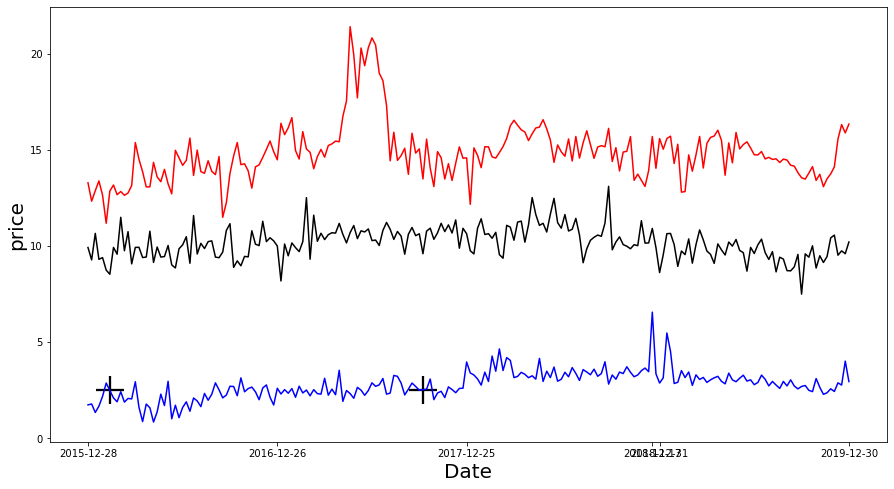

In [8]:
plt.figure(figsize = (15,8))
sns.lineplot(data = ts['salmon'], color = 'red')
sns.lineplot(data = ts['ojing'], color = 'blue')
sns.lineplot(data = ts['saewoo'], color = 'black')
plt.ylabel('price', size=20)
plt.xlabel('Date', size=20)
plt.xticks([0, 52, 104, 155, 157, 209], year_end) # x축 라벨을 연말을 기준으로 표현
sns.scatterplot(x = [6, 92], y = [2.5, 2.5], marker = '+', s = 800, color = 'black')  # 오징어 결측치

#### 전처리 - 결측치 대체

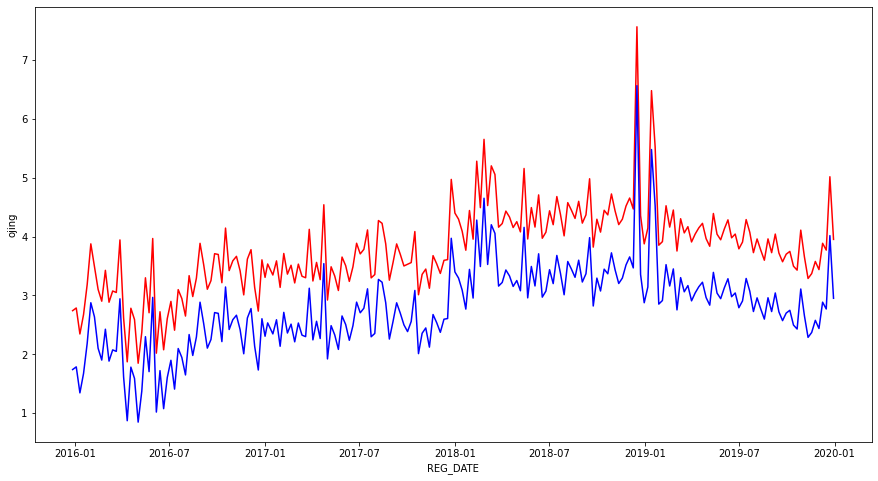

In [73]:
# 결측치 내삽, 계절성이 없는 데이터의 경우 linear method만 사용
ts = ts.set_index('REG_DATE')
ts_intp = (ts.interpolate('linear', axis = 0) + ts.interpolate('quadratic', axis = 0) + ts.interpolate('cubic', axis = 0))/3
# 결측치 대치 대상 변수
intp_variable = 'ojing'

# 내삽 전 후 비교 (용이한 비교를 위해 내삽 전 관측치에 +1)
plt.figure(figsize = (15,8))
sns.lineplot(data = ts[intp_variable] + 1, color = 'red') # 내삽 전
sns.lineplot(data = ts_intp[intp_variable], color = 'blue') # 내삽 후

ts = ts_intp

In [9]:
ts = ts.set_index('REG_DATE')
ts

,salmon,ojing,saewoo
REG_DATE,,,
2015-12-28,13.287212,1.741647,9.922919
2016-01-04,12.331994,1.787152,9.279109
2016-01-11,12.876513,1.345855,10.658746
2016-01-18,13.387350,1.675178,9.308712
2016-01-25,12.644323,2.185579,9.399535
...,...,...,...
2019-12-02,14.114510,2.439093,10.567506
2019-12-09,15.565930,2.886105,9.523846
2019-12-16,16.314381,2.770290,9.749197


#### 시계열 분해

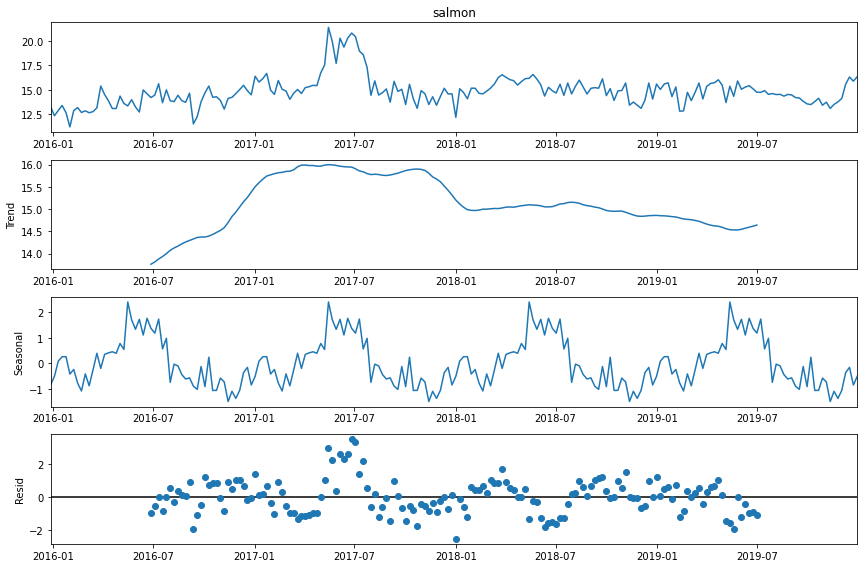

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts.index = pd.date_range(start=ts.index[0], end=ts.index[-1], freq='7D')

# 분해 대상 변수
dcmp = 'salmon'

result = seasonal_decompose(ts[dcmp], model='additive')
# model = 'additive' -> 추세와 계절성이 독립
# model = 'multiplicative' -> 추세와 계절성이 독립

plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

#### 정상성 검정 

#### * ACF, PACF

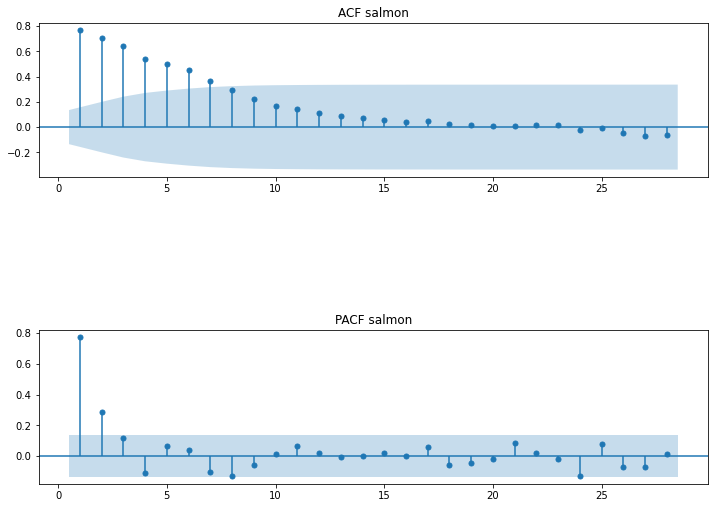

In [80]:
import statsmodels.graphics.tsaplots as sgt

# 대상 변수
acf_variable = 'salmon'

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(ts[acf_variable], lags = 28, zero = False, ax=ax1)
ax1.set_title("ACF " + acf_variable)


sgt.plot_pacf(ts[acf_variable], lags = 28, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF " + acf_variable)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.show()

* ACF가 매우 느리게 감소 : 비정상성 (차분 필요)

* 정상 시계열로 판단할 수 있음

#### * ADF Test : 시계열이 안정적(stationary)인지

In [81]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df) :
    result = adfuller(df.values)
    print('ADF statistics : %f' % result[0])
    print('P-value : %f' % result[1])
    print('Critical values :')
    for k, v in result[4].items():
        print('\t%s : %.3f' % (k, v))
        
# 대상 변수
adf_variable = 'salmon'
print('adf result')
print('variable : ' + adf_variable)
adf_test(ts[adf_variable])

adf result
variable : salmon
ADF statistics : -3.402312
P-value : 0.010880
Critical values :
	1% : -3.462
	5% : -2.876
	10% : -2.574


* null : 시계열이 비정상성을 띔
* 기각 실패 : 비정상 시계열 / 기각 : 정상 시계열


* p_value=0.01이라 기각역을 어떻게 설정하느냐에 따라 판단 달라짐

#### * KPSS Test : 시계열이 평균 또는 선형 추세 주변에 고정되어 있는지 

In [82]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df) :
    result = kpss(df.values)
    print('KPSS statistics : %f' % result[0])
    print('P-value : %f' % result[1])
    print('# of lags : %f' % result[2])
    print('Critical values :')
    for k, v in result[3].items():
        print('\t%s : %.3f' % (k, v))

# 대상 변수
kpss_variable = 'salmon'
print('kpss result')
print('variable : ' + kpss_variable)
adf_test(ts[kpss_variable])

kpss result
variable : salmon
ADF statistics : -3.402312
P-value : 0.010880
Critical values :
	1% : -3.462
	5% : -2.876
	10% : -2.574


* null : 정상 시계열

#### 변수 상관 분석 : CCF


* 여러 시계열 간의 관계를 파악, 시계열간의 선행(lead), 후행(lag)관계가 존재하는 지 파악
   - 실업률 증가 3개월 후 주택 가격이 하락 (주택 가격은 실업률의 후행 지표)
   - 실업률 급증 한 달 전에 대중교통 수요가 증가 (대중교통 수요는 실업률의 선행지표)
   
   
* 선행지표는 특정 시계열의 예측변수, 후행 지표는 관련된 정책 수립등에 이용될 수 있음

* (y_t, x_t) : y_t가 x-계열의 과거 시차와 관계될 수 있음
  - y_t의 예측에 유용하게 사용될 수 있는 x-변수의 시차(lags)를 찾는데 유용
  
  
  
* x_t+h가 y_t의 예측변수로 사용되고 h가 음수 : x leads y
* x_t+h가 y_t의 예측변수로 사용되고 h가 양수 : x lags y


* 계절성으로 인한 허구적 상관성에 유의 (차분윽ㄹ 통해 두 계열간의 순수한 선형적 연관을 확인할 수 있음)

In [84]:
import numpy as np
import scipy.signal as ss

def ccf_udf(x, y, lag_max):

    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

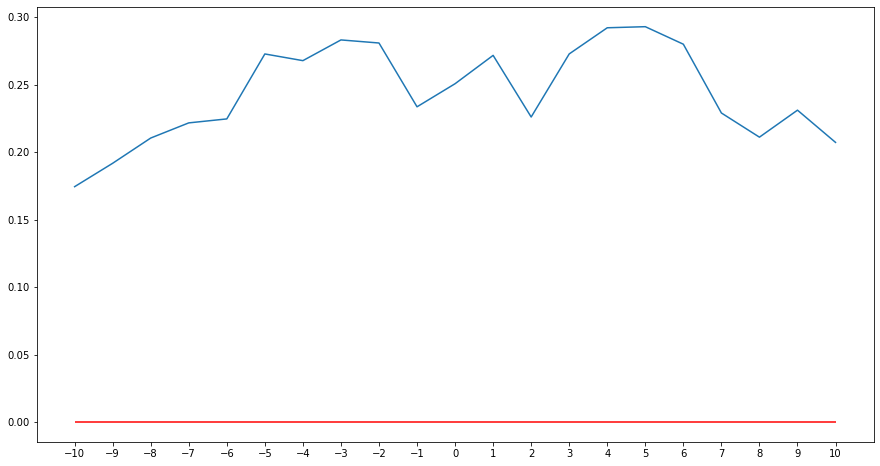

In [85]:
lag_max = 10

ccf_x_variable = 'salmon'
ccf_y_variable = 'saewoo'

plt.figure(figsize = (15,8))
plt.plot(list(range(-lag_max, lag_max+1)), list(ccf_udf(ts[ccf_x_variable], ts[ccf_y_variable], lag_max = lag_max)))
plt.hlines(y = 0, xmin = -lag_max, xmax = lag_max, color = 'red')
plt.xticks(list(range(-lag_max, lag_max+1)))
plt.show()

# ccf : correlation(x(t), y(t+k))

#### 그래인저 인과 검정


* 동일한 시간축의 범위를 가진 두 데이터가 있을 때 한 데이터를 다른 한쪽 데이터의 특정한 시간 간격에 대해 선형 회귀가 가능하면 그래인저 인과관계가 존재


* 정상성 가정 필요


In [86]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

dataset = ts
grangers_causality_matrix(dataset, variables = dataset.columns)

,salmon_x,ojing_x,saewoo_x
salmon_y,1.0000,0.4423,0.1379
ojing_y,0.4850,1.0000,0.0096
saewoo_y,0.0041,0.0302,1.0000
